In [1]:
import os
import sys
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

Prior libraries required: cellpose, mayavi

installation instructions: 
- cellpose: ```pip install cellpose```, check update via option ```--update```
- mayavi: <br>
```pip install mayavi``` <br>
```pip install PyQt5``` <br>
For jupyter notebook interactive plot: <br>
```jupyter nbextension install --py mayavi --user``` <br>
```jupyter nbextension enable --py mayavi --user```

Reference for those libraries: <br>
- [cellpose](https://github.com/MouseLand/cellpose)
- [mayavi](https://docs.enthought.com/mayavi/mayavi/installation.html)

In [2]:
from matplotlib import colors
from scipy import ndimage as ndi
from cp_segment import Cellpose_3d


In [3]:
from mayavi import mlab
mlab.init_notebook()

Notebook initialized with ipy backend.


### Utility functions

In [31]:
##########################
# Read ims files
##########################
class ImsReader():
    """Retrieve numpy array from IMS image files"""

    def __init__(self, fname, res=0, tp=0):
        self.ims = h5py.File(fname, 'r')
        self.res = 'ResolutionLevel {}'.format(res)
        self.tp = 'TimePoint {}'.format(tp)

    def to_numpy(self, channel):
        """Return the 3-dimensional [C,H,W] np.array of a particular channel of the image"""
        ch_name = 'Channel {}'.format(channel)
        img = self.ims['DataSet'][self.res][self.tp][ch_name]['Data'][()]
        img_rescaled = self._rescale_3d(img)

        return img_rescaled

    def num_channels(self):
        """Count total number of separate channels"""
        return len(self.ims['DataSet'][self.res][self.tp])

    def _rescale_3d(self, img):
        """Rescale intensity per z-axis"""
        img_rescaled = []
        for i, layer in enumerate(img):
            img_rescaled.append(self._rescale(layer))

        return np.array(img_rescaled)

    def _rescale(self, img, eps=1e-6):
        """Rescale a 2-dimension image to (0, 1)"""
        return (img - img.min()) / (img.max() - img.min() + eps)

    
def load_ims(path, res=0, channel=None, tp=0):
    """
    Load 3D images from all ims files in the input directory

    Parameters
    ----------
    path : str
        Directory to ims files

    res : int
        Image resolution level from ims file
        (0: 2048*2048, 1: 1024*1024, 2: 512*512, 3: 256*256)

    channel : int
        Stained channel to import
        (default: None - import image from all channels)

    tp : int
        Time point for loaded images

    Returns
    -------
    output : dict or list
        Dictionary of (channel, list of 3D np.array) if load all channels
        List of 3D np.array if load specific channel
    """
    assert os.path.exists(path), "Invalid input path {0}".format(path)
    fnames = [os.path.join(path, name) for name in sorted(os.listdir(path))]
    if channel is None:
        print('Loading images from all channels...')
        n_channels = ImsReader(fname=fnames[0]).num_channels()
        channels = np.arange(n_channels)
        output = {i: [] for i in range(n_channels)}
    else:
        print('Loading images from channel {}'.format(channel))
        channels = [channel]
        output = {channel: []}

    for name in fnames:
        ims = ImsReader(fname=name, res=res, tp=tp)
        for ch in channels:
            output[ch].append(ims.to_numpy(ch))

    return output if channel is None else output[channel]


##########################
# mRNA transcript counts
##########################



# reference: https://stackoverflow.com/questions/46626267/how-to-generate-a-sphere-in-3d-numpy-array/46626448
def generate_sphere(shape, radius, position):
    """Generate 3D mask based on the sphere"""
    # assume shape and position are both a 3-tuple of int or float
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    semisizes = (radius,) * 3

    # genereate the grid for the support points
    # centered at the position indicated by position
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    # calculate the distance of all points from `position` center
    # scaled by the radius
    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        # this can be generalized for exponent != 2
        # in which case `(x_i / semisize)`
        # would become `np.abs(x_i / semisize)`
        arr += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below 1
    return (arr <= 1.0).astype(np.float)


def generate_mrna_mask(blobs, shape):
    mask = np.zeros(shape)
    radii = blobs[:,-1] * np.sqrt(3)
    positions = blobs[:,:-1]
    
    for i, (pos, r) in enumerate(zip(positions, radii)):
        pos = tuple(pos)
        mask_individual = generate_sphere(shape, r, pos)
        mask += mask_individual
        
    return (mask > 0).astype(np.float)


def transcript_count(nuclei_mask, mrna_mask, count_outliers=True):
    """Count number of mRNA molecules assigned to each nuclei"""
    # first stage: quantify by mRNA transcript inside nuclei
    mrna_counts = []
    for label in np.unique(nuclei_mask)[1:]:
        mrna_counts.append(ndi.label(np.bitwise_and(nuclei_mask == label, mrna_mask == 1))[1])
        
    # count mRNA dots outsie nuclei volume (assign to the nearest neighbor)
    if count_outliers:
        outside_mask = np.bitwise_and(nuclei_mask == 0, mrna_mask == 1).astype(np.float)
        coords = ndi.distance_transform_edt(np.bitwise_or(nuclei_mask == 0, outside_mask == 1),
                                            return_distances=False,
                                            return_indices=True)
        coords[:, outside_mask == 0] = -1
        coords = coords.reshape(3, -1).T
        coords_mask = [coord[0] != -1 for coord in coords]
        coords = coords[coords_mask]
        
        nn_assignments = nuclei_mask[tuple(coords.T)]
        for label in nn_assignments:
            mrna_counts[label-1] += 1
            
    return mrna_counts


def calc_transcript_prop(nuclei_mask, mrna_mask):
    """Calculate the proportion of mrna transcript dot residing within the nuclei mask"""
    nuclei_mask_binary = (nuclei_mask > 0).astype(np.float)
    total_count = (mrna_mask > 0).sum()
    outside_count = ((mrna_mask - nuclei_mask_binary) == 1).sum()
    prop = (total_count - outside_count) / total_count
    
    return np.round(prop, 3)


##########################
# Visualization
##########################

# 3D plot via mayavi
@mlab.show
def plot_3d(img, slice=False, contours=4, color=None, axis='z'):
    mlab.figure(size=(1000, 800))
    if slice:
        res = mlab.volume_slice(img, colormap='jet')
    else:
        if color is not None:
            res = mlab.contour3d(img.transpose(1,2,0), color=color)
        else:
            res = mlab.contour3d(img.transpose(1,2,0), contours=contours, transparent=True)
    mlab.axes(line_width=0.5)
    mlab.outline()

    return res

### Segmentation

#### (1). Gut tissue

In [5]:
%%bash
ls ../datasets/gut_Jellert_lab/raw_ims/

20200204_membrane_ab_Epcam_ECad_CD45_p2-TI-FF_2_F0.ims
20200204_membrane_ab_Epcam_ECad_CD45_p2-TI-FF_2_F1.ims
20200204_membrane_ab_Epcam_ECad_CD45_p2-TI-FF_2_F3.ims
20200204_membrane_ab_Epcam_ECad_CD45_p2-TI-FF_2_F4.ims
20200204_membrane_ab_Epcam_ECad_CD45_p2-TI-FF_2_F5.ims
20200204_membrane_ab_Epcam_ECad_CD45_p2-TI-FF_2_F6.ims
20200204_membrane_ab_Epcam_ECad_CD45_p2-TI-FF_2_F7.ims
20200204_membrane_ab_Epcam_ECad_CD45_p2-TI-FF_2_F8.ims


The ims files provide 4 different resolutions
- [2048 x 2048] res - 0
- [1024 x 1024] res - 1
- [512 x 512]   res - 2
- [256 x 256]   res - 3

For simplicity choose (256, 256)

In [6]:
# load ims files
gut_data_path = '../datasets/gut_Jellert_lab/raw_ims/'
gut_profiles = load_ims(gut_data_path, res=3)

Loading images from all channels...


Visualize images for channel information

In [7]:
print('Number of channels: {}'.format(gut_profiles.keys()))

Number of channels: dict_keys([0, 1, 2])


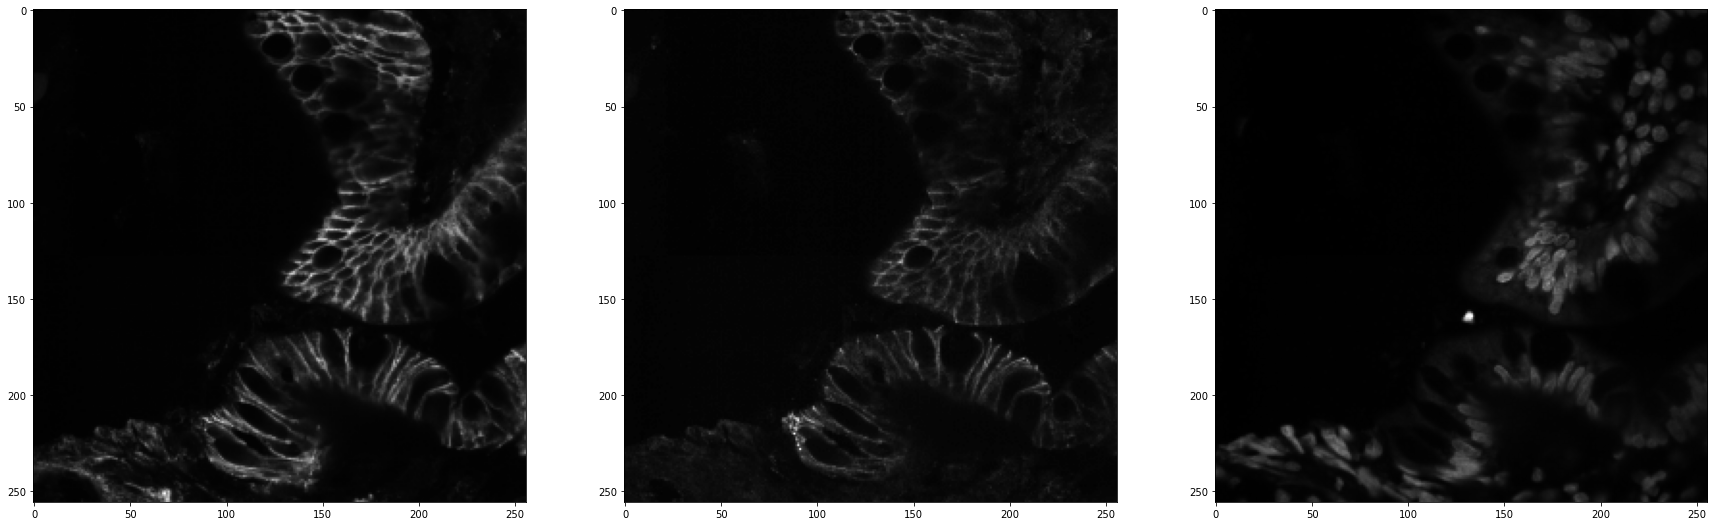

In [8]:
z_depth = gut_profiles[0][0].shape[0] // 2  # visualize the middle z-layer


plt.figure(figsize=(30, 10))
plt.subplot(1,3,1)
plt.imshow(gut_profiles[0][0][z_depth], cmap='gray') # first image in channel 0
plt.subplot(1,3,2)
plt.imshow(gut_profiles[1][0][z_depth], cmap='gray') # first image in channel 1
plt.subplot(1,3,3)
plt.imshow(gut_profiles[2][0][z_depth], cmap='gray') # first image in channel 2
plt.show()


The plot above shows that channel 0 & 1 are membrane channels, channel 2 is nuclei channel.

Perform segmentation on nuclei channel, choose the 1st image as an example

In [14]:
?Cellpose_3d

In [9]:
gut_nuclei_img = gut_profiles[2][0]
gut_nuclei_res =  Cellpose_3d(gut_nuclei_img,
                              model_type='nuclei',  # model_type: {'nuclei', 'cyto'}
                              est_diam=True, # whether to estimate nuclei diameter with 2D segmentation
                              use_gpu=False, # depending on machine cuda capacity
                             )    

>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
** TORCH CUDA version installed and working. **
>>>> using GPU
processing 1 image(s)
computing styles from images
time spent: running network 0.11s; flow+mask computation 0.63
estimated cell diameters for 1 image(s) in 0.99 sec
>>> diameter(s) =  [6.48204481]


/home/yinuo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
  0%|          | 0/12 [00:00<?, ?it/s]

time spent: running network 0.69s; flow+mask computation 0.55
estimated masks for 1 image(s) in 1.24 sec
>>>> TOTAL TIME 2.23 sec
processing 1 image(s)
multi-stack tiff read in as having 24 planes 1 channels

 running YX: 24 planes of size (256, 256) 




  0%|          | 0/32 [00:00<?, ?it/s]


 running ZY: 256 planes of size (24, 256) 




  0%|          | 0/32 [00:00<?, ?it/s]


 running ZX: 256 planes of size (24, 256) 




100%|██████████| 32/32 [00:30<00:00,  1.05it/s]


flows computed 390.61s
dynamics computed 390.74s
masks computed 391.66s
estimated masks for 1 image(s) in 392.63 sec
>>>> TOTAL TIME 392.63 sec


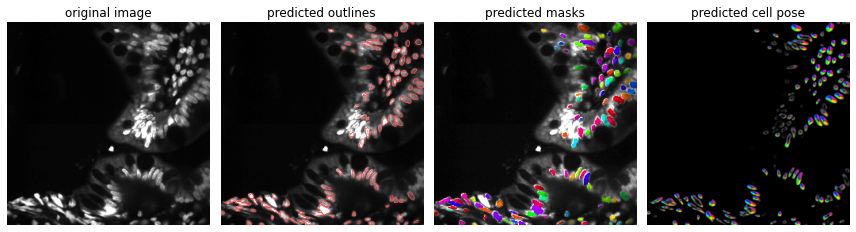

In [15]:
gut_nuclei_res.disp_2d_slice()

In [16]:
# Visualize 3d segmentation via contour plot
gut_nuclei_res.disp_3d_contour()

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x03 \x08\x02\x00\x00\x00?z\xdfj\x00\…

Alternatively, we can visually estimate how well Cellpose performs the cells by looking at the segmentation results along z-axiz. With "slice" plot we can scroll the interactive plot back & forth.

In [17]:
gut_nuclei_res.disp_3d_slice()

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x03 \x08\x02\x00\x00\x00?z\xdfj\x00\…

Perform segmentation on membrane channel (e.g. Ecad), choose the 1st image as an example

In [21]:
gut_membrane_img = gut_profiles[0][0]
gut_membrane_res =  Cellpose_3d(gut_membrane_img,
                                model_type='cyto', 
                                est_diam=False, 
                                use_gpu=False)  

  0%|          | 0/6 [00:00<?, ?it/s]

>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
multi-stack tiff read in as having 24 planes 1 channels

 running YX: 24 planes of size (256, 256) 




  0%|          | 0/24 [00:00<?, ?it/s]


 running ZY: 256 planes of size (24, 256) 




  0%|          | 0/24 [00:00<?, ?it/s]


 running ZX: 256 planes of size (24, 256) 




100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


flows computed 224.78s
dynamics computed 225.28s
masks computed 226.56s
estimated masks for 1 image(s) in 227.49 sec
>>>> TOTAL TIME 227.49 sec


In [23]:
# Visualize 3d segmentation via contour plot
gut_membrane_res.disp_3d_contour()

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x03 \x08\x02\x00\x00\x00?z\xdfj\x00\…

As shown above, the contour visualization doesn't work quite well for membrane segmentation results, since most of the cells share adjacent membrane borders. Let's show the segmentation via 2d slices.

In [24]:
gut_membrane_res.disp_3d_slice()

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x03 \x08\x02\x00\x00\x00?z\xdfj\x00\…

#### (2). liver tissue (with mRNA dots)

In [11]:
liver_tissue_path = '../datasets/liver_Jellert_lab/raw_ims/'
liver_profiles = load_ims(liver_tissue_path, res=3)

Loading images from all channels...


Visualize images for channel information

In [12]:
print('Number of channels: {}'.format(liver_profiles.keys()))

Number of channels: dict_keys([0, 1, 2, 3])


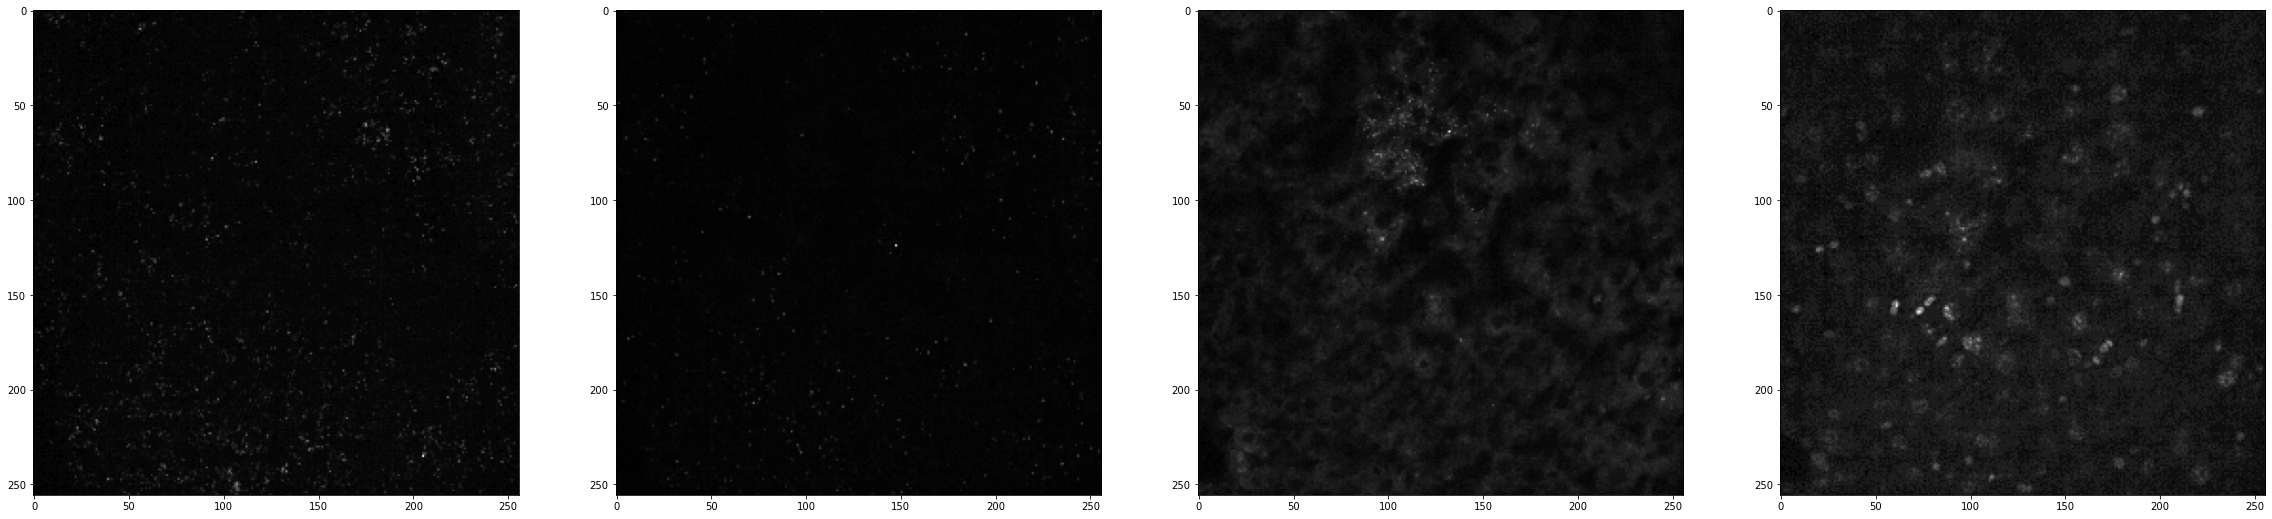

In [13]:
z_depth = liver_profiles[0][0].shape[0] // 2  # visualize the middle z-layer

plt.figure(figsize=(40, 10))
plt.subplot(1,4,1)
plt.imshow(liver_profiles[0][0][z_depth], cmap='gray') # first image in channel 0
plt.subplot(1,4,2)
plt.imshow(liver_profiles[1][0][z_depth], cmap='gray') # first image in channel 1
plt.subplot(1,4,3)
plt.imshow(liver_profiles[2][0][z_depth], cmap='gray') # first image in channel 2
plt.subplot(1,4,4)
plt.imshow(liver_profiles[3][0][z_depth], cmap='gray') # first image in channel 3
plt.show()


Perform segmentation on nuclei channel, choose the 1st image as an example

In [14]:
liver_nuclei_img = liver_profiles[3][0]
liver_nuclei_res = Cellpose_3d(liver_nuclei_img,
                               model_type='nuclei', 
                               est_diam=True, 
                               use_gpu=False)  

>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
** TORCH CUDA version installed and working. **
>>>> using GPU
processing 1 image(s)
computing styles from images
time spent: running network 0.17s; flow+mask computation 0.80
estimated cell diameters for 1 image(s) in 1.07 sec
>>> diameter(s) =  [4.91849076]


  0%|          | 0/8 [00:00<?, ?it/s]

time spent: running network 0.81s; flow+mask computation 0.78
estimated masks for 1 image(s) in 1.59 sec
>>>> TOTAL TIME 2.66 sec
processing 1 image(s)
multi-stack tiff read in as having 16 planes 1 channels

 running YX: 16 planes of size (256, 256) 




  0%|          | 0/43 [00:00<?, ?it/s]


 running ZY: 256 planes of size (16, 256) 




  0%|          | 0/43 [00:00<?, ?it/s]


 running ZX: 256 planes of size (16, 256) 




100%|██████████| 43/43 [00:38<00:00,  1.12it/s]


flows computed 465.00s
dynamics computed 465.05s
masks computed 465.44s
estimated masks for 1 image(s) in 466.10 sec
>>>> TOTAL TIME 466.10 sec


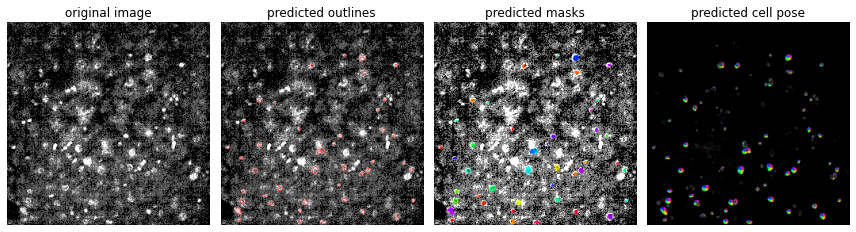

In [25]:
liver_nuclei_res.disp_2d_slice()

In [26]:
liver_nuclei_res.disp_3d_contour()

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x03 \x08\x02\x00\x00\x00?z\xdfj\x00\…

In [27]:
liver_nuclei_res.disp_3d_slice()

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x03 \x08\x02\x00\x00\x00?z\xdfj\x00\…

Perform mRNA transcript detection & counting, visualize results in 3d <br>
Color order: red, green, cyan

In [32]:
from skimage.feature import blob_log
from matplotlib import colors

In [30]:
mrna_preds = []
mrna_pred_spheres = [] # craete sphere plots for visualization

for i in range(3):
    mrna_img = liver_profiles[i][0] # use the first image as an example
    blob = blob_log(mrna_img, max_sigma=30, threshold=0.1)
    
    # save detected mrna dot locations
    coords = blob[:,:-1].astype(int)
    pred = np.zeros_like(mrna_img)
    pred[tuple(coords.T)] = 1
    
    # generate spheres
    mrna_pred_sphere = generate_mrna_mask(blob, mrna_img.shape)
    mrna_preds.append(pred)
    mrna_pred_spheres.append(mrna_pred_sphere)

/home/yinuo/anaconda3/lib/python3.8/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/yinuo/anaconda3/lib/python3.8/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/yinuo/anaconda3/lib/python3.8/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/yinuo/anaconda3/lib/python3.8/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/yinuo/anaconda3/lib/python3.8/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/yinuo/anaconda3/lib/python3.8/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid va

Visualize detected mRNA dots

Red:

In [33]:
plot_3d(mrna_pred_spheres[0], color=colors.to_rgb('red'))

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x03 \x08\x02\x00\x00\x00?z\xdfj\x00\…

Green:

In [35]:
plot_3d(mrna_pred_spheres[1], color=colors.to_rgb('green'))

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x03 \x08\x02\x00\x00\x00?z\xdfj\x00\…

Cyan:

In [36]:
plot_3d(mrna_pred_spheres[2], color=colors.to_rgb('cyan'))

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x03 \x08\x02\x00\x00\x00?z\xdfj\x00\…

There are some "clustering" effects for the "cyan" channel, which indicates some noises either from the optics side or image preprocessing side. We potentially want mRNA speckles separable so that the quantification could be more accurate.

#### Cell x Marker count matrix 
Although the given liver dataset doesn't contain membrane channel, we can still construct the cell by count matrix through pseudo-count (assigning mRNA dots located outside predicted nuclei to their closest neighbors)

In [37]:
liver_nuclei_mask = liver_nuclei_res.masks
mrna_counts = [] # order: red, green, cyan

for pred in mrna_preds:
    mrna_counts.append(transcript_count(liver_nuclei_mask, pred))

Calculate how many mRNA predictions reside inside nuclei regions:

In [38]:
def calc_transcript_prop(nuclei_mask, mrna_mask):
    """Calculate the proportion of mrna transcript dot residing within the nuclei mask"""
    nuclei_mask_binary = (nuclei_mask > 0).astype(np.float)
    total_count = (mrna_mask > 0).sum()
    outside_count = ((mrna_mask - nuclei_mask_binary) == 1).sum()
    prop = (total_count - outside_count) / total_count
    
    return np.round(prop, 3)

In [39]:
print('{}% red mRNA dots reside within predicted nuclei masks'.format(
    calc_transcript_prop(liver_nuclei_mask, mrna_preds[0])))

print('{}% red mRNA dots reside within predicted nuclei masks'.format(
    calc_transcript_prop(liver_nuclei_mask, mrna_preds[1])))

print('{}% red mRNA dots reside within predicted nuclei masks'.format(
    calc_transcript_prop(liver_nuclei_mask, mrna_preds[2])))

0.008% red mRNA dots reside within predicted nuclei masks
0.028% red mRNA dots reside within predicted nuclei masks
0.019% red mRNA dots reside within predicted nuclei masks


Create Cell x Marker matrix:

In [43]:
num_cells = len(mrna_counts[0])

counts_df = pd.DataFrame({'ALB': mrna_counts[0], 'PCK1': mrna_counts[1], 'GLUL': mrna_counts[2]})
counts_df.index.name = 'Cell_ID'

counts_df.head()

,ALB,PCK1,GLUL
Cell_ID,,,
0,9,4,4
1,11,2,8
2,5,3,0
3,7,0,3
4,4,2,0


The next steps will be doing some quantifications based on the clustering results to see how exclusively those markers express.